### Imports

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF, RationalQuadratic
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

### Read and preprocess the data

In [55]:
df_mp = pd.read_csv('/home/april-ai/Desktop/UQ/MP_Data/materials_data_10k_cleaned.csv')

In [56]:
df_mp = df_mp[(df_mp['band_gap'] > 0.2)]
y = df_mp['band_gap']

In [57]:
df_mp.head()

,nsites,composition,formula_pretty,volume,density,symmetry,material_id,structure,formation_energy_per_atom,energy_above_hull,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
1,24,Zn1 As2,ZnAs2,558.344218,5.121352,"{'crystal_system': 'Monoclinic', 'symbol': 'P2...",mp-7262,"{'@module': 'pymatgen.core.structure', '@class...",-0.148991,0.0,...,0.0,0.0,0.0,0.0,166.0,194.0,28.0,175.333333,12.444444,166.0
2,16,Li1 As1,LiAs,287.389201,3.784027,"{'crystal_system': 'Monoclinic', 'symbol': 'P2...",mp-7943,"{'@module': 'pymatgen.core.structure', '@class...",-0.588209,0.0,...,0.0,0.0,0.0,0.0,166.0,229.0,63.0,197.500000,31.500000,166.0
3,10,Cd1 P4,CdP4,206.572949,3.799098,"{'crystal_system': 'Monoclinic', 'symbol': 'P2...",mp-7904,"{'@module': 'pymatgen.core.structure', '@class...",-0.120743,0.0,...,0.0,0.0,0.0,0.0,2.0,194.0,192.0,40.400000,61.440000,2.0
4,16,Na1 Sb1,NaSb,477.144588,4.030018,"{'crystal_system': 'Monoclinic', 'symbol': 'P2...",mp-7944,"{'@module': 'pymatgen.core.structure', '@class...",-0.448723,0.0,...,0.0,0.0,0.0,0.0,166.0,229.0,63.0,197.500000,31.500000,166.0
6,16,Li1 P1,LiP,248.527196,2.026625,"{'crystal_system': 'Monoclinic', 'symbol': 'P2...",mp-9588,"{'@module': 'pymatgen.core.structure', '@class...",-0.616667,0.0,...,0.0,0.0,0.0,0.0,2.0,229.0,227.0,115.500000,113.500000,2.0


### Train-test split

In [58]:

# Step 1: Define and clean inputs
y = df_mp['band_gap'].values
excluded = ["material_id", "composition", "formula_pretty", "symmetry", "structure", "sites"]
X = df_mp.drop(columns=excluded + ["band_gap"], errors='ignore')

#
original_indices = df_mp.index.to_numpy()
formulas = df_mp.loc[original_indices, "formula_pretty"].values

# Step 4: Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Feature selection AFTER scaling
X_selected = SelectKBest(score_func=f_regression, k=137).fit_transform(X_scaled, y)

# Step 6: Train-test split on selected features and aligned y
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_selected, y, original_indices, test_size=0.2, random_state=42
)


In [59]:
#X_scaled.shape
X_selected.shape

(921, 137)

In [60]:
# Normalise training data
#scaler_x = StandardScaler()
#scaler_y = StandardScaler()


#X_train = scaler_x.fit_transform(X_train_raw) #computes mean and std from training data and scales it
#X_test = scaler_x.transform(X_test_raw) #uses the same mean and std to scale test data


#y_train = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1)).ravel()
#y_test = scaler_y.transform(y_test_raw.values.reshape(-1, 1)).ravel() #ravel() flattens the output back to 1D, which is typically needed for PyTorch models expecting targets as flat vectors.

#scaler_x = StandardScaler()
#X_train = scaler_x.fit_transform(X_train)
#X_test = scaler_x.transform(X_test)

## Run Gaussian Process Regression 

In [61]:
kernel = (
    ConstantKernel(1.0, (1e-3, 1e6)) *
    (RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e6)) +
     Matern(length_scale=1.0, nu=2.5, length_scale_bounds=(1e-5, 1e6)) +
     RationalQuadratic(length_scale=1.0, alpha=1.0, alpha_bounds=(1e-5, 1e7)))
    + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-12, 10))
)
#kernel = ConstantKernel(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, nu=2.5) + WhiteKernel(noise_level=1e-3)
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=30, normalize_y=True)
gpr.fit(X_train, y_train)

# Predict with uncertainty
y_pred, y_std = gpr.predict(X_test, return_std=True)

# Evaluate
print("R² score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

print("Optimized kernel:", gpr.kernel_)

R² score: 0.5945223028606075
RMSE: 0.9100409069763048
Optimized kernel: 1.38**2 * RBF(length_scale=22) + Matern(length_scale=20.5, nu=2.5) + RationalQuadratic(alpha=0.0278, length_scale=1.37) + WhiteKernel(noise_level=1e-06)


In [62]:
pipe = Pipeline([
    ('select', SelectKBest(score_func=f_regression)),
    ('gpr', GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True))
])

param_grid = {
    'select__k': [20, 30, 50, 100, 120, 137],  # 137 is the max
    'gpr__alpha': [1e-10, 1e-8, 1e-6]
}

search = GridSearchCV(pipe, param_grid, cv=3, scoring='r2', n_jobs=-1)
search.fit(X_scaled, y)
print("Best R2:", search.best_score_)
print("Best params:", search.best_params_)

/home/april-ai/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/april-ai/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 17 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/april-ai/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-12. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best R2: 0.5670338500398692
Best params: {'gpr__alpha': 1e-08, 'select__k': 30}


In [63]:

scores = cross_val_score(gpr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("CV RMSE:", np.sqrt(-scores).mean())

KeyboardInterrupt: 

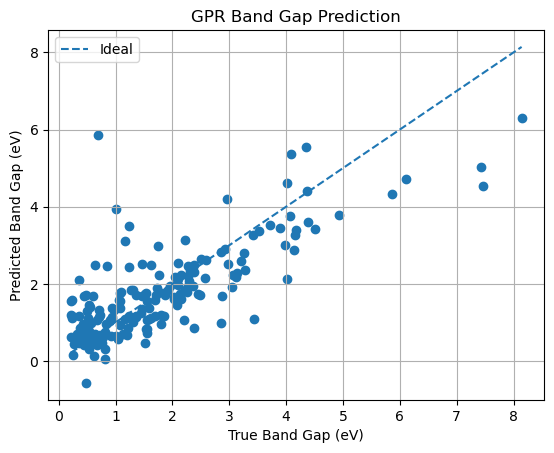

In [ ]:
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', label='Ideal')
plt.xlabel('True Band Gap (eV)')
plt.ylabel('Predicted Band Gap (eV)')
plt.title('GPR Band Gap Prediction')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:


# Get cross-validated predictions ( 5-fold)
y_pred_cv = cross_val_predict(gpr, X_train, y_train, cv=5)



/home/april-ai/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-09. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


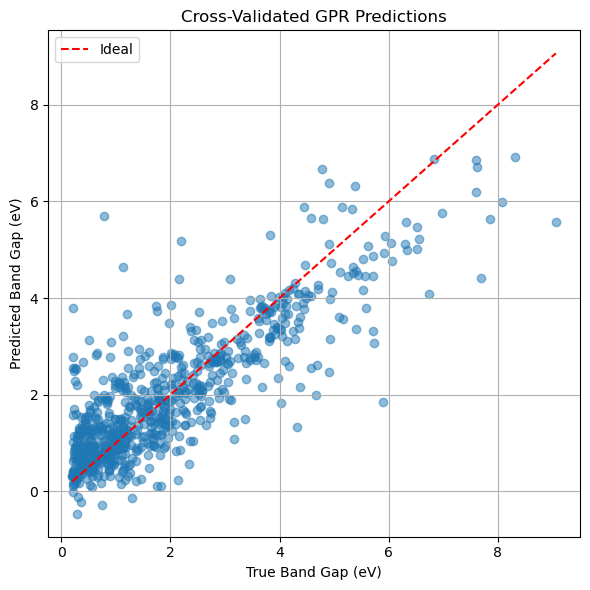

In [ ]:
# Plot true vs predicted (cross-validated)
plt.figure(figsize=(6,6))
plt.scatter(y_train, y_pred_cv, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', label='Ideal')
plt.xlabel('True Band Gap (eV)')
plt.ylabel('Predicted Band Gap (eV)')
plt.title('Cross-Validated GPR Predictions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

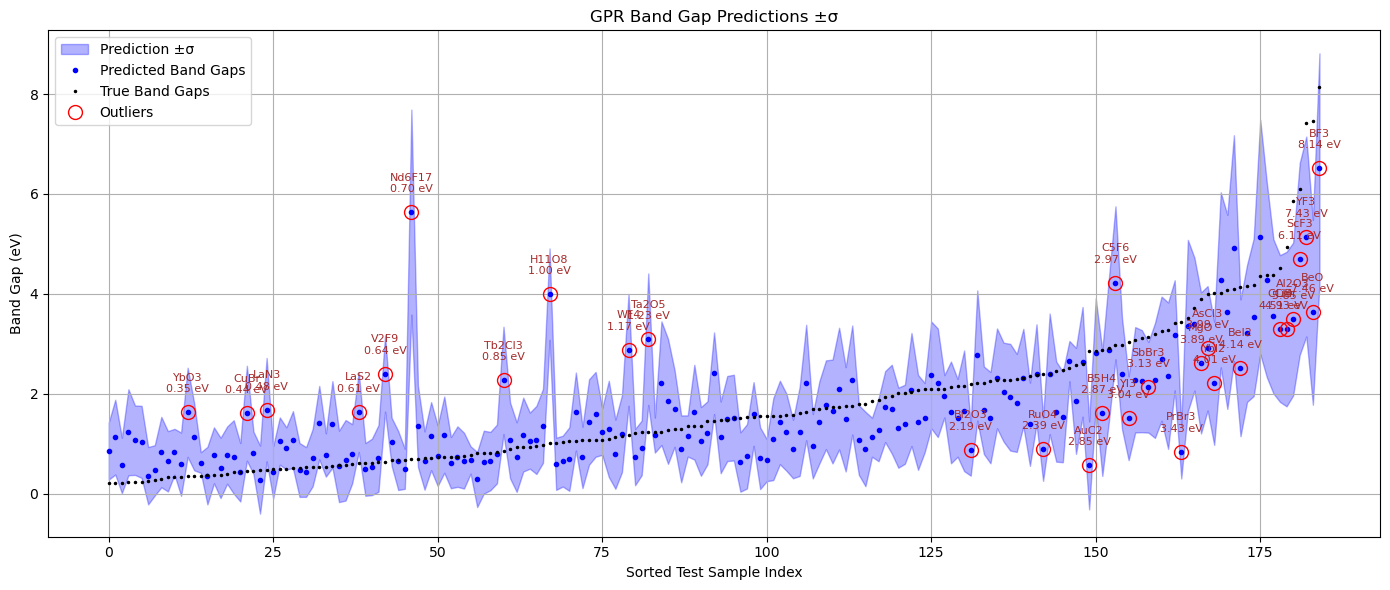

In [ ]:

y_true = np.array(y_test)
y_predicted = np.array(y_pred)
y_std_dev = np.array(y_std)

# Sort by true band gap values
sorted_idx = np.argsort(y_true)
y_true_sorted = y_true[sorted_idx]
y_pred_sorted = y_predicted[sorted_idx]
y_std_sorted = y_std_dev[sorted_idx]

# 95% confidence interval
lower = y_pred_sorted -  y_std_sorted
upper = y_pred_sorted + y_std_sorted

# Optional: get formulas for annotation
formulas = df_mp.loc[idx_test, "formula_pretty"].values
formulas_sorted = formulas[sorted_idx]

# Calculate prediction error
errors = np.abs(y_true_sorted - y_pred_sorted)
outlier_mask = errors > 1
outlier_indices = np.where(outlier_mask)[0]

# Plot
plt.figure(figsize=(14, 6))

# Confidence interval band
plt.fill_between(range(len(y_true_sorted)), lower, upper, alpha=0.3, label='Prediction ±σ', color='blue')

# Predicted mean
plt.plot(y_pred_sorted, 'o', markersize=3, label='Predicted Band Gaps', color='blue')

# True values
plt.plot(y_true_sorted, 'k.', markersize=3, label='True Band Gaps')

# Outliers
plt.plot(outlier_indices, y_pred_sorted[outlier_mask], 'ro', markerfacecolor='none', markersize=10, label='Outliers')

# Annotate outliers
for i in outlier_indices:
    plt.text(i, y_pred_sorted[i] + 0.4, f"{formulas_sorted[i]}\n{y_true_sorted[i]:.2f} eV", 
             fontsize=8, color='brown', ha='center')

# Final formatting
plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("GPR Band Gap Predictions ±σ")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


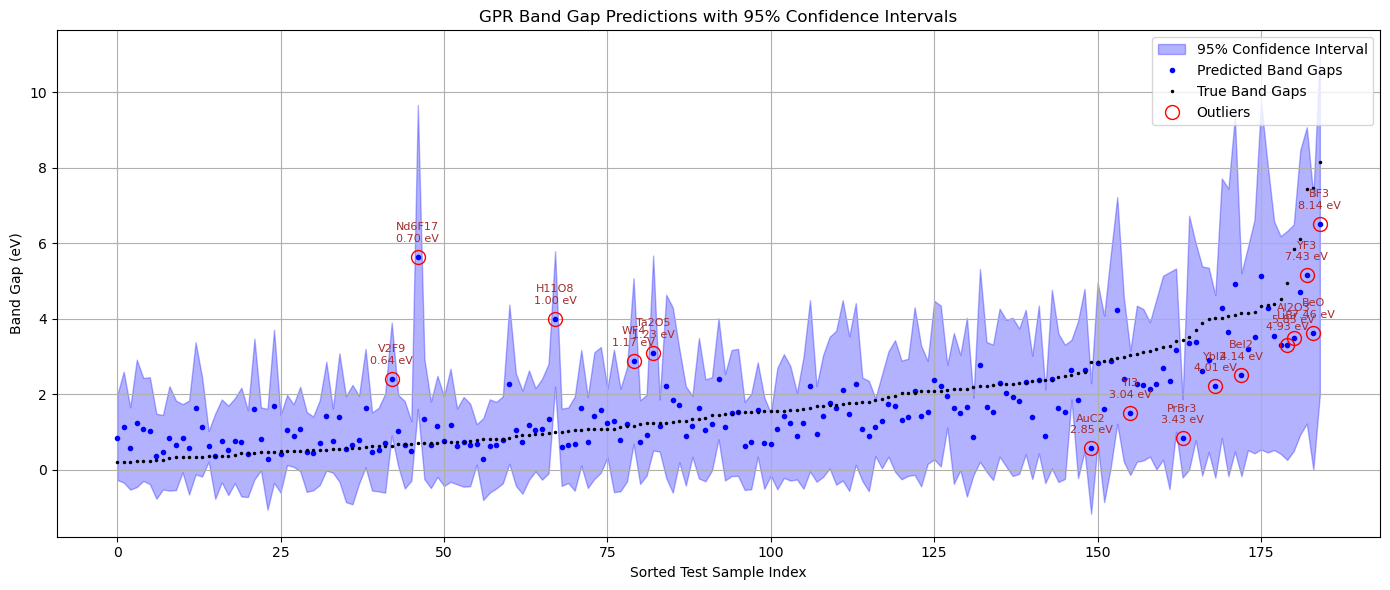

In [ ]:
# Convert y_test_raw and y_pred to numpy arrays for indexing
y_true = np.array(y_test)
y_predicted = np.array(y_pred)
y_std_dev = np.array(y_std)

# Sort by true band gap values
sorted_idx = np.argsort(y_true)
y_true_sorted = y_true[sorted_idx]
y_pred_sorted = y_predicted[sorted_idx]
y_std_sorted = y_std_dev[sorted_idx]

# 95% confidence interval
lower = y_pred_sorted - 1.96 * y_std_sorted
upper = y_pred_sorted + 1.96 * y_std_sorted

# Optional: get formulas for annotation
formulas = df_mp.loc[idx_test, "formula_pretty"].values
formulas_sorted = formulas[sorted_idx]

# Calculate prediction error
errors = np.abs(y_true_sorted - y_pred_sorted)
outlier_mask = errors > 1.5
outlier_indices = np.where(outlier_mask)[0]

# Plot
plt.figure(figsize=(14, 6))

# Confidence interval band
plt.fill_between(range(len(y_true_sorted)), lower, upper, alpha=0.3, label='95% Confidence Interval', color='blue')

# Predicted mean
plt.plot(y_pred_sorted, 'o', markersize=3, label='Predicted Band Gaps', color='blue')

# True values
plt.plot(y_true_sorted, 'k.', markersize=3, label='True Band Gaps')

# Outliers
plt.plot(outlier_indices, y_pred_sorted[outlier_mask], 'ro', markerfacecolor='none', markersize=10, label='Outliers')

# Annotate outliers
for i in outlier_indices:
    plt.text(i, y_pred_sorted[i] + 0.4, f"{formulas_sorted[i]}\n{y_true_sorted[i]:.2f} eV", 
             fontsize=8, color='brown', ha='center')

# Final formatting
plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("GPR Band Gap Predictions with 95% Confidence Intervals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Log-transformed data training

In [ ]:
# Before fitting
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)
gpr.fit(X_train, y_train_log)
y_pred_log, y_std_log = gpr.predict(X_test, return_std=True)
y_pred = np.expm1(y_pred_log)
y_std = np.expm1(y_pred_log + y_std_log) - y_pred  # Approximate std in original space

# Step 9: Evaluate
print("R² score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

print("Optimized kernel:", gpr.kernel_)

NameError: name 'np' is not defined

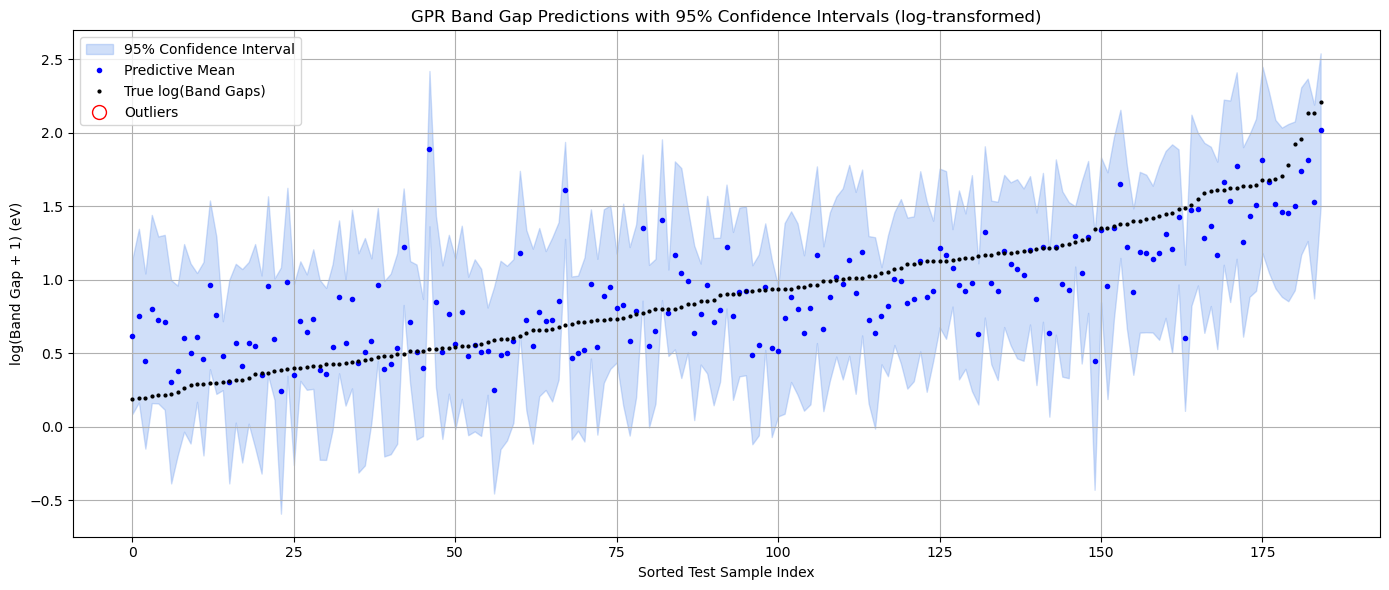

In [ ]:
# Visualize log-transformed GPR predictions with 95% confidence interval

# Convert to numpy arrays
y_true_log = np.array(y_test_log)
y_pred_log = np.array(y_pred_log)
y_std_log = np.array(y_std_log)

# Sort by true log band gap values
sorted_idx = np.argsort(y_true_log)
y_true_log_sorted = y_true_log[sorted_idx]
y_pred_log_sorted = y_pred_log[sorted_idx]
y_std_log_sorted = y_std_log[sorted_idx]

# 95% confidence interval in log space
lower_log = y_pred_log_sorted - 1.96 * y_std_log_sorted
upper_log = y_pred_log_sorted + 1.96 * y_std_log_sorted

# Optional: get formulas for annotation
formulas = df_mp.loc[idx_test, "formula_pretty"].values
formulas_sorted = formulas[sorted_idx]

# Calculate prediction error (in log space)
errors_log = np.abs(y_true_log_sorted - y_pred_log_sorted)
outlier_mask = errors_log > 1.5  # adjust threshold as needed for log space
outlier_indices = np.where(outlier_mask)[0]

# Plot
plt.figure(figsize=(14, 6))

# Confidence interval band
plt.fill_between(range(len(y_true_log_sorted)), lower_log, upper_log, alpha=0.3, label='95% Confidence Interval', color='cornflowerblue')

# Predicted mean
plt.plot(y_pred_log_sorted, 'o', markersize=3, label='Predictive Mean', color='blue')

# True values
plt.plot(y_true_log_sorted, 'k.', markersize=4, label='True log(Band Gaps)')

# Outliers
plt.plot(outlier_indices, y_true_log_sorted[outlier_mask], 'ro', markerfacecolor='none', markersize=10, label='Outliers')

# Annotate outliers
for i in outlier_indices:
    plt.text(i, y_true_log_sorted[i] + 0.2, f"{formulas_sorted[i]}\n{y_true_log_sorted[i]:.2f}", 
             fontsize=8, color='brown', ha='center')

# Final formatting
plt.xlabel("Sorted Test Sample Index")
plt.ylabel("log(Band Gap + 1) (eV)")
plt.title("GPR Band Gap Predictions with 95% Confidence Intervals (log-transformed)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

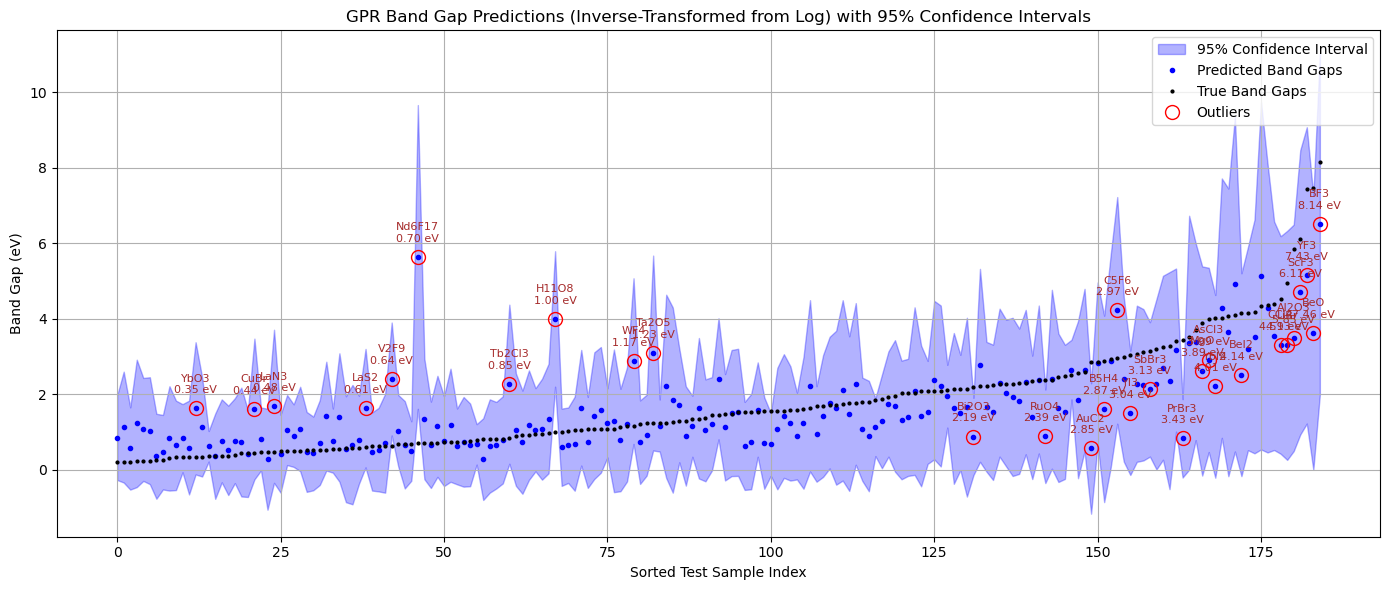

In [ ]:
# After predicting in log space, inverse-transform to original band gap scale and plot
# Inverse-transform log-predicted and true values
y_true = np.expm1(y_test_log)
y_pred = np.expm1(y_pred_log)
y_std = np.expm1(y_pred_log + y_std_log) - y_pred  # Approximate std in original space

# Sort by true band gap values for a clearer plot
sorted_idx = np.argsort(y_true)
y_true_sorted = y_true[sorted_idx]
y_pred_sorted = y_pred[sorted_idx]
y_std_sorted = y_std[sorted_idx]

# 95% confidence interval
lower = y_pred_sorted - 1.96 * y_std_sorted
upper = y_pred_sorted + 1.96 * y_std_sorted

# Optional: get formulas for annotation
formulas = df_mp.loc[idx_test, "formula_pretty"].values
formulas_sorted = formulas[sorted_idx]

# Calculate prediction error
errors = np.abs(y_true_sorted - y_pred_sorted)
outlier_mask = errors > 1
outlier_indices = np.where(outlier_mask)[0]

# Plot
plt.figure(figsize=(14, 6))

# Confidence interval band
plt.fill_between(range(len(y_true_sorted)), lower, upper, alpha=0.3, label='95% Confidence Interval', color='blue')

# Predicted mean
plt.plot(y_pred_sorted, 'o', markersize=3, label='Predicted Band Gaps', color='blue')

# True values
plt.plot(y_true_sorted, 'k.', markersize=4, label='True Band Gaps')

# Outliers
plt.plot(outlier_indices, y_pred_sorted[outlier_mask], 'ro', markerfacecolor='none', markersize=10, label='Outliers')

# Annotate outliers
for i in outlier_indices:
    plt.text(i, y_pred_sorted[i] + 0.4, f"{formulas_sorted[i]}\n{y_true_sorted[i]:.2f} eV", 
             fontsize=8, color='brown', ha='center')

# Final formatting
plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("GPR Band Gap Predictions (Inverse-Transformed from Log) with 95% Confidence Intervals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [73]:
from sklearn.pipeline           import Pipeline
from sklearn.compose            import TransformedTargetRegressor
from sklearn.preprocessing      import StandardScaler, FunctionTransformer
from sklearn.feature_selection  import SelectKBest, f_regression
from sklearn.gaussian_process   import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (ConstantKernel, RBF, Matern,
                                              RationalQuadratic, WhiteKernel)
import numpy as np


In [74]:
log1p = FunctionTransformer(np.log1p, inverse_func=np.expm1)


In [78]:
n_feat = X_train.shape[1]               # 137 in your data

kernel = (ConstantKernel(1.0, (0.1, 10.0)) *
          (RBF(length_scale=1.0,      length_scale_bounds=(1e-2, 1e3)) +
           Matern(length_scale=1.0,    length_scale_bounds=(1e-2, 1e3), nu=2.5) +
           RationalQuadratic(length_scale=1.0, alpha=1.0,
                             length_scale_bounds=(1e-2, 1e3),
                             alpha_bounds=(1e-4, 1e4)))
          + WhiteKernel(noise_level=1e-4,
                        noise_level_bounds=(1e-9, 1e1)))



In [79]:
gpr = GaussianProcessRegressor(
        kernel=kernel,
        alpha=1e-5,                 # fixed jitter added to the diagonal
        optimizer="fmin_l_bfgs_b",  # default
        n_restarts_optimizer=8,
        normalize_y=False,
        random_state=42)

pipe = Pipeline([
    ("scale",  StandardScaler()),                 # MUST come first
    ("select", SelectKBest(f_regression, k=60)),  # k is tunable
    ("gpr",    gpr)
])

model = TransformedTargetRegressor(regressor=pipe,
                                   transformer=log1p)  # log ↔ expm1 on y


In [80]:
from sklearn.model_selection import GridSearchCV, KFold

param_grid = {
    "regressor__select__k":   [40, 60, 90],   # try a few
    "regressor__gpr__alpha":  [1e-6, 1e-5]    # bigger α = safer numerically
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

search = GridSearchCV(model,
                      param_grid   = param_grid,
                      scoring      = "r2",
                      cv           = cv,
                      n_jobs       = -1,
                      verbose      = 1)
search.fit(X_train, y_train)

print("CV-best R² :", search.best_score_)
print("Params     :", search.best_params_)
print("Kernel     :", search.best_estimator_.regressor_["gpr"].kernel_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


/home/april-ai/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-09. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/april-ai/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/april-ai/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/april-ai/anaconda3/lib/python3.11/

CV-best R² : 0.6771144360531632
Params     : {'regressor__gpr__alpha': 1e-06, 'regressor__select__k': 90}
Kernel     : 0.855**2 * RBF(length_scale=16.7) + Matern(length_scale=44.1, nu=2.5) + RationalQuadratic(alpha=0.0235, length_scale=1.4) + WhiteKernel(noise_level=1e-09)


/home/april-ai/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-09. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


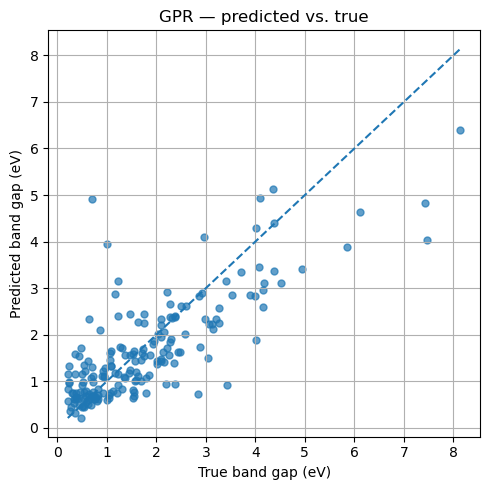

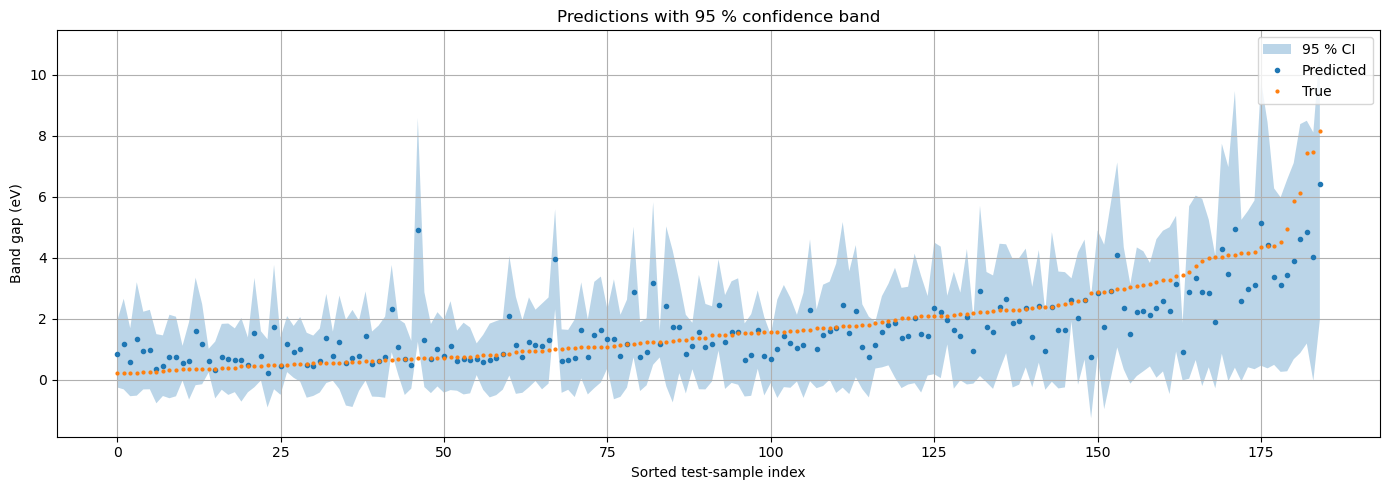

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# ── 1 ▸ grab the best fitted model ────────────────────────────────────────────
best_model   = search.best_estimator_          # TransformedTargetRegressor
reg_pipeline = best_model.regressor_           # the X-pipeline + DynamicGPR

# ── 2 ▸ quick helper to invert log targets ────────────────────────────────────
def inv(x): return np.expm1(x)

# ── 3 ▸ scatter: predicted vs true ────────────────────────────────────────────
y_pred_lin = inv(reg_pipeline.predict(X_test))        # μ in eV
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(y_test, y_pred_lin, s=25, alpha=0.7)
ax.plot([y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()], linestyle="--")
ax.set_xlabel("True band gap (eV)")
ax.set_ylabel("Predicted band gap (eV)")
ax.set_title("GPR — predicted vs. true")
ax.grid(True)
plt.tight_layout()
plt.show()

# ── 4 ▸ sorted curve with 95 % CI ─────────────────────────────────────────────
y_pred_log, y_std_log = reg_pipeline.predict(X_test, return_std=True)
y_true_log            = log1p.transform(y_test.reshape(-1, 1)).ravel()

y_true = inv(y_true_log)
y_pred = inv(y_pred_log)
y_std  = inv(y_pred_log + y_std_log) - y_pred    # ≈ σ in eV

idx          = np.argsort(y_true)
y_true_s     = y_true[idx]
y_pred_s     = y_pred[idx]
y_std_s      = y_std[idx]

lower = y_pred_s - 1.96 * y_std_s
upper = y_pred_s + 1.96 * y_std_s

fig, ax = plt.subplots(figsize=(14, 5))
ax.fill_between(np.arange(len(y_true_s)), lower, upper, alpha=0.30,
                label="95 % CI")
ax.plot(y_pred_s, "o", ms=3, label="Predicted")
ax.plot(y_true_s, ".", ms=4, label="True")
ax.set_xlabel("Sorted test-sample index")
ax.set_ylabel("Band gap (eV)")
ax.set_title("Predictions with 95 % confidence band")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()
